In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [10]:
bulk_df = pd.read_csv('../in_vivo_tumor/c169743b-102a-42fe-9590-bc5d01789441tumor.count.txt', sep='\t', index_col=0)
bulk_df['geneID'] = ['sg' + gene + '_gene' if gene.startswith('Non') else 'sg' + gene + '_' + str(2 - int(idx[-1]) % 2) + '_gene' for gene, idx in zip(bulk_df.Gene, bulk_df.index)]
order_bulk = bulk_df[['RNA-B304', 'geneID']].set_index('geneID', drop=True).sort_values(by='RNA-B304', ascending=False)

In [11]:
file_path = '/home/wpy/stereoseq/20240802-Tumor/RNA/B03502E5.gem'
df = pd.read_csv(file_path, header=0, index_col=0, sep='\t', comment='#')

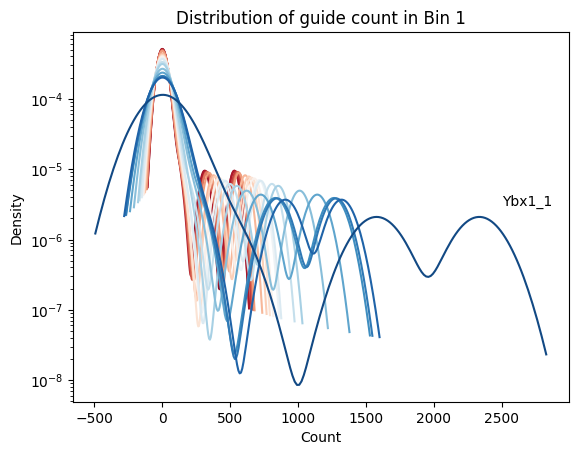

In [12]:
import seaborn as sns
pdf = df.groupby('geneID')['MIDCount'].value_counts().unstack().fillna(0)
pdf['sum'] = pdf.sum(axis=1)
pdf.sort_values(by='sum', inplace=True, ascending=False)
pdf = pdf.iloc[:20]
sns.kdeplot(pdf.T, fill=False, palette='RdBu_r', legend=False)
plt.text(2500, 3e-6, 'Ybx1_1')
plt.xlabel('Count')
plt.title('Distribution of guide count in Bin 1')
plt.gca().set_yscale('log')

In [13]:
dup = df[df.duplicated(subset=['x', 'y'], keep=False)]
dup.drop_duplicates(subset=['x', 'y'])

,x,y,MIDCount,ExonCount
geneID,,,,
sgNon-targeting_42_gene,4696,13904,1,1
sgNon-targeting_42_gene,7769,13324,1,1
sgNon-targeting_42_gene,6907,16342,1,1
sgNon-targeting_42_gene,6237,17557,1,1
sgNon-targeting_42_gene,6639,16765,1,1
...,...,...,...,...
sgFxyd5_2_gene,9084,11670,1,1
sgNfib_2_gene,15595,15041,1,1
sgCxadr_2_gene,9345,19186,1,1


In [14]:
single = df.drop_duplicates()
single

,x,y,MIDCount,ExonCount
geneID,,,,
sgNon-targeting_42_gene,4696,13904,1,1
sgNon-targeting_42_gene,7769,13324,1,1
sgNon-targeting_42_gene,6907,16342,1,1
sgNon-targeting_42_gene,6237,17557,1,1
sgNon-targeting_42_gene,13369,7839,1,1
...,...,...,...,...
sgPdzk1ip1_1_gene,11591,8882,4,4
sgPdzk1ip1_1_gene,16551,1757,1,1
sgPdzk1ip1_1_gene,13181,17219,1,1


Text(0.5, 1.0, 'Count Distribution of bin 1 across sample')

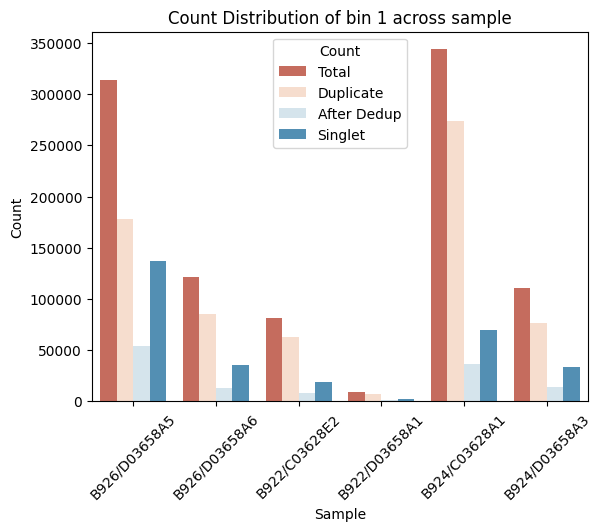

In [15]:
pdf = pd.DataFrame(columns=['Total', 'Duplicate', 'After Dedup', 'Singlet'])
for sample in ['B926/D03658A5', 'B926/D03658A6', 'B922/C03628E2', 'B922/D03658A1', 'B924/C03628A1', 'B924/D03658A3']:
    file_path = "~/stereoseq/20240502-SPACseq/gRNA/" + sample
    guide_df = pd.read_csv(file_path + '.guide.gem', header=0, index_col=0, sep='\t', comment='#')
    cdf = pd.DataFrame({
        'Total': guide_df.shape[0],
        'After Dedup': guide_df[guide_df.duplicated(subset=['x', 'y'], keep=False)].drop_duplicates(subset=['x', 'y']).shape[0],
        'Singlet': guide_df.drop_duplicates(subset=['x', 'y']).shape[0],
    }, index=[sample])
    cdf['Duplicate'] = cdf['Total'] - cdf['Singlet']
    pdf = pd.concat([pdf, cdf])
pdf = pdf.T.melt()
pdf['Count'] = ['Total', 'Duplicate', 'After Dedup', 'Singlet'] * 6
sns.barplot(pdf, x='variable', y='value', hue='Count', palette='RdBu')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Sample')
plt.title('Count Distribution of bin 1 across sample')

In [16]:
pear = {}

In [17]:
# nothing to do
order_cnt = df.reset_index().groupby(by='geneID')[['MIDCount']].sum().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Raw data'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount'])

In [19]:
# assign without filter
order_cnt = df.reset_index().groupby(by='geneID')[['MIDCount']].count().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Binary'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount'])

In [20]:
# filter without assign
dup = df[df.duplicated(subset=['x', 'y'], keep=False)].reset_index()
dup.groupby(['x', 'y'])[['geneID', 'MIDCount']].max().reset_index()
dup['ExonCount'] = dup['MIDCount']
single = df.drop_duplicates(subset=['x', 'y']).reset_index()
order_cnt = pd.concat([dup, single]).reset_index(drop=True).groupby('geneID')[['MIDCount']].sum().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Assign max'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount'])

In [21]:
# filter with assign
dup = df[df.duplicated(subset=['x', 'y'], keep=False)].reset_index()
dup.groupby(['x', 'y'])[['geneID', 'MIDCount']].max().reset_index()
dup['ExonCount'] = dup['MIDCount']
single = df.drop_duplicates(subset=['x', 'y']).reset_index()
order_cnt = pd.concat([dup, single]).reset_index(drop=True).groupby('geneID')[['MIDCount']].count().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Assign max and binary'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount'])

In [22]:
# dropout without assign
single = df.drop_duplicates(subset=['x', 'y']).reset_index()
order_cnt = single.reset_index(drop=True).groupby('geneID')[['MIDCount']].sum().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Drop duplicates'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount'])

In [23]:
# drop threshold with assign
dup = df[df.duplicated(subset=['x', 'y'], keep=False)].reset_index()
dup.groupby(['x', 'y'])[['geneID', 'MIDCount']].max().reset_index()
dup['ExonCount'] = dup['MIDCount']
dup = dup[dup.MIDCount > 1]
single = df.drop_duplicates(subset=['x', 'y']).reset_index()
single = single[single.MIDCount > 1]
order_cnt = pd.concat([dup, single]).reset_index(drop=True).groupby('geneID')[['MIDCount']].count().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Drop low and binary'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount']) 

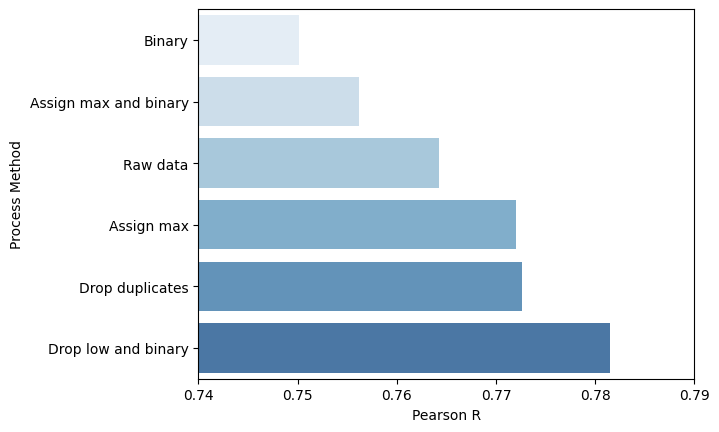

In [25]:
r_dict = {}
for r in pear:
    r_dict[r] = pear[r][0]
df = pd.DataFrame(r_dict, index=['r']).T.reset_index().sort_values(by='r')
sns.barplot(df, y='index', x='r', hue='index', palette='Blues', alpha=0.8)
plt.xlim([0.74, 0.79])
plt.xlabel('Pearson R')
plt.ylabel('Process Method')
plt.show()

In [45]:
file_path = '/home/wpy/stereoseq/in_vivo_tumor/B03502E5/out_/B03502E5-1/04.output/B03502E5.gem'
df = pd.read_csv(file_path, header=0, index_col=0, sep='\t', comment='#')

In [27]:
# nothing to do
order_cnt = df.reset_index().groupby(by='geneID')[['MIDCount']].sum().sort_values(by='MIDCount', ascending=False)

order_bulk['rank'] = list(range(1, len(order_bulk.index) + 1))
order_cnt['rank'] = list(range(1, len(order_cnt.index) + 1))

t_df = pd.concat([order_bulk, order_cnt], axis=1).fillna(0).sort_values('MIDCount', ascending=False).head(50)
pear['Mismatch = 0'] = pearsonr(t_df['RNA-B304'], t_df['MIDCount'])

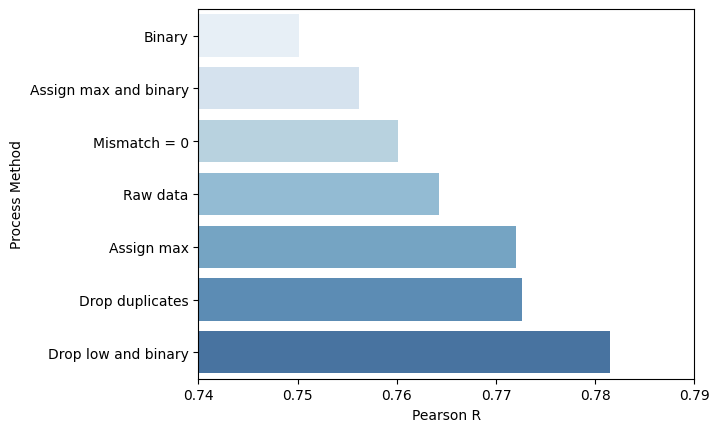

In [28]:
r_dict = {}
for r in pear:
    r_dict[r] = pear[r][0]
df = pd.DataFrame(r_dict, index=['r']).T.reset_index().sort_values(by='r')
sns.barplot(df, y='index', x='r', hue='index', palette='Blues', alpha=0.8)
plt.xlim([0.74, 0.79])
plt.xlabel('Pearson R')
plt.ylabel('Process Method')
plt.show()

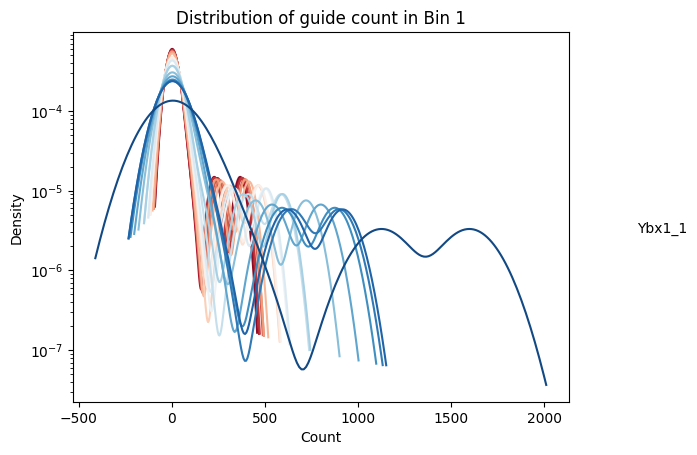

In [46]:
import seaborn as sns
pdf = df.groupby('geneID')['MIDCount'].value_counts().unstack().fillna(0)
pdf['sum'] = pdf.sum(axis=1)
pdf.sort_values(by='sum', inplace=True, ascending=False)
pdf = pdf.iloc[:20]
sns.kdeplot(pdf.T, fill=False, palette='RdBu_r', legend=False)
plt.text(2500, 3e-6, 'Ybx1_1')
plt.xlabel('Count')
plt.title('Distribution of guide count in Bin 1')
plt.gca().set_yscale('log')

Text(0.5, 1.0, 'Count Distribution of bin 1 across sample')

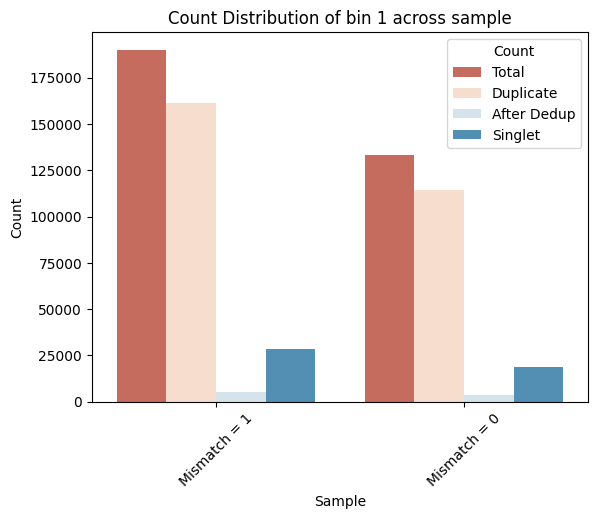

In [55]:
pdf = pd.DataFrame(columns=['Total', 'Duplicate', 'After Dedup', 'Singlet'])
for sample in ['/home/wpy/stereoseq/in_vivo_tumor/B03502E5/out/B03502E5-1/04.output/B03502E5', 
    "/home/wpy/stereoseq/in_vivo_tumor/B03502E5/out_/B03502E5-1/04.output/B03502E5"]:
    file_path = sample
    guide_df = pd.read_csv(file_path + '.gem', header=0, index_col=0, sep='\t', comment='#')
    cdf = pd.DataFrame({
        'Total': guide_df.shape[0],
        'After Dedup': guide_df[guide_df.duplicated(subset=['x', 'y'], keep=False)].drop_duplicates(subset=['x', 'y']).shape[0],
        'Singlet': guide_df.drop_duplicates(subset=['x', 'y']).shape[0],
    }, index=[sample])
    cdf['Duplicate'] = cdf['Total'] - cdf['Singlet']
    pdf = pd.concat([pdf, cdf])
pdf = pdf.T.melt()
pdf['Count'] = ['Total', 'Duplicate', 'After Dedup', 'Singlet'] * 2
sns.barplot(pdf, x='variable', y='value', hue='Count', palette='RdBu')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Sample')
plt.xticks([0, 1], ['Mismatch = 1', 'Mismatch = 0'])
plt.title('Count Distribution of bin 1 across sample')